# Proyecto mineria de datos

coordinates plot libraries

In [1]:
import json
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')

from mpl_toolkits.basemap import Basemap
from scipy.misc import imread


Text mining libraries

In [2]:
import codecs
import glob
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import string
import time

#nltk.download()
%matplotlib inline
from ggplot import *
from math import log
from matplotlib import pyplot as plt
from nltk import sent_tokenize, word_tokenize
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy import ndimage
from sklearn import manifold, datasets
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity

## Load

In [3]:
with open('test2.json') as data_file:    
    data = json.load(data_file)

### Data structure

In [4]:
print "páginas de registros:", len(data)
print "claves por página:", data[0].keys()
print "claves de \"photos\":" ,data[0]["photos"].keys()
print "fotos por página", len(data[0]["photos"]["photo"])
print "claves por \"photo\"",pd.DataFrame( data[0]["photos"]["photo"][0].keys() )

páginas de registros: 500
claves por página: [u'photos', u'stat']
claves de "photos": [u'photo', u'total', u'pages', u'page', u'perpage']
fotos por página 250
claves por "photo"                        0
0              pathalias
1          geo_is_public
2               place_id
3           media_status
4                  owner
5                     id
6   datetakengranularity
7                  woeid
8          geo_is_friend
9         geo_is_contact
10             datetaken
11              isfriend
12                secret
13             ownername
14              latitude
15              accuracy
16              isfamily
17                 media
18           description
19                  tags
20                  farm
21         geo_is_family
22      datetakenunknown
23              ispublic
24                 url_s
25             longitude
26                server
27               context
28              height_s
29                 title
30               width_s


## Preprocessing

### Load and cleaning data

In [5]:
Lat_l=[]
Long_l=[]
Tags_l=[]
Ids_l=[]
Urls_l=[]
Datetaken_l=[]
Ownername_l=[]
Description_l=[]
Title_l=[]

for datas in data:
    Lat_datas=[float(pic["latitude"]) for pic in datas["photos"]["photo"]]
    Long_datas=[float(pic["longitude"]) for pic in datas["photos"]["photo"]]
    Tags_datas=[pic["tags"] for pic in datas["photos"]["photo"]]
    Ids_datas=[pic["id"] for pic in datas["photos"]["photo"]]
    Urls_datas=[pic["url_s"] for pic in datas["photos"]["photo"]]
    Datetaken_datas=[pic["datetaken"] for pic in datas["photos"]["photo"]]
    Ownername_datas=[pic["ownername"] for pic in datas["photos"]["photo"]]
    Description_datas=[pic["description"]["_content"] for pic in datas["photos"]["photo"]]
    Title_datas=[pic["title"] for pic in datas["photos"]["photo"]]
    
    Lat_l.extend(Lat_datas)
    Long_l.extend(Long_datas)
    Tags_l.extend(Tags_datas)
    Ids_l.extend(Ids_datas)
    Urls_l.extend(Urls_datas)
    Datetaken_l.extend(Datetaken_datas)
    Ownername_l.extend(Ownername_datas)
    Description_l.extend(Description_datas)
    Title_l.extend(Title_datas)



### Removing repeated data

In [6]:
Ids=list(set(Ids_l))
Lat=[Lat_l[Ids_l.index(pict)]for pict in Ids]
Long=[Long_l[Ids_l.index(pict)]for pict in Ids]
Tags=[Tags_l[Ids_l.index(pict)]for pict in Ids]

Datetaken=[Datetaken_l[Ids_l.index(pict)]for pict in Ids]
Ownername=[Ownername_l[Ids_l.index(pict)]for pict in Ids]
Description=[Description_l[Ids_l.index(pict)]for pict in Ids]
Title=[Title_l[Ids_l.index(pict)]for pict in Ids]

print "Latitudes",len(Lat),"Longitudes",len(Long),"Tags",len(Tags)
#print "Fechas", len(Datetaken), "Usuarios", len(Ownername), "Descripciones",len(Description), "Títulos",len(Title)#, "",len(),

Latitudes 4000 Longitudes 4000 Tags 4000


In [7]:
# Create a unique string of the texts found on tags, titles and descriptions:
Texts=[]
for i in range(len(Ids)):
    Texts.append(" ".join ([Title[i],Description[i],Tags[i]]))

print len (Texts)

4000


## Plot coordinates of the pictures

### Bogotá coordinates

East long=-73.98

West long=-74.23

North lat=4.84

South lat=4.46

In [8]:
North=4.84
South=4.46
East=-73.98
West=-74.23

def map_dim(wide):
    high_m=abs(North-South)
    wide_m=abs(East-West)
    ratio=high_m/wide_m
    return([float(wide),float(wide)*ratio])

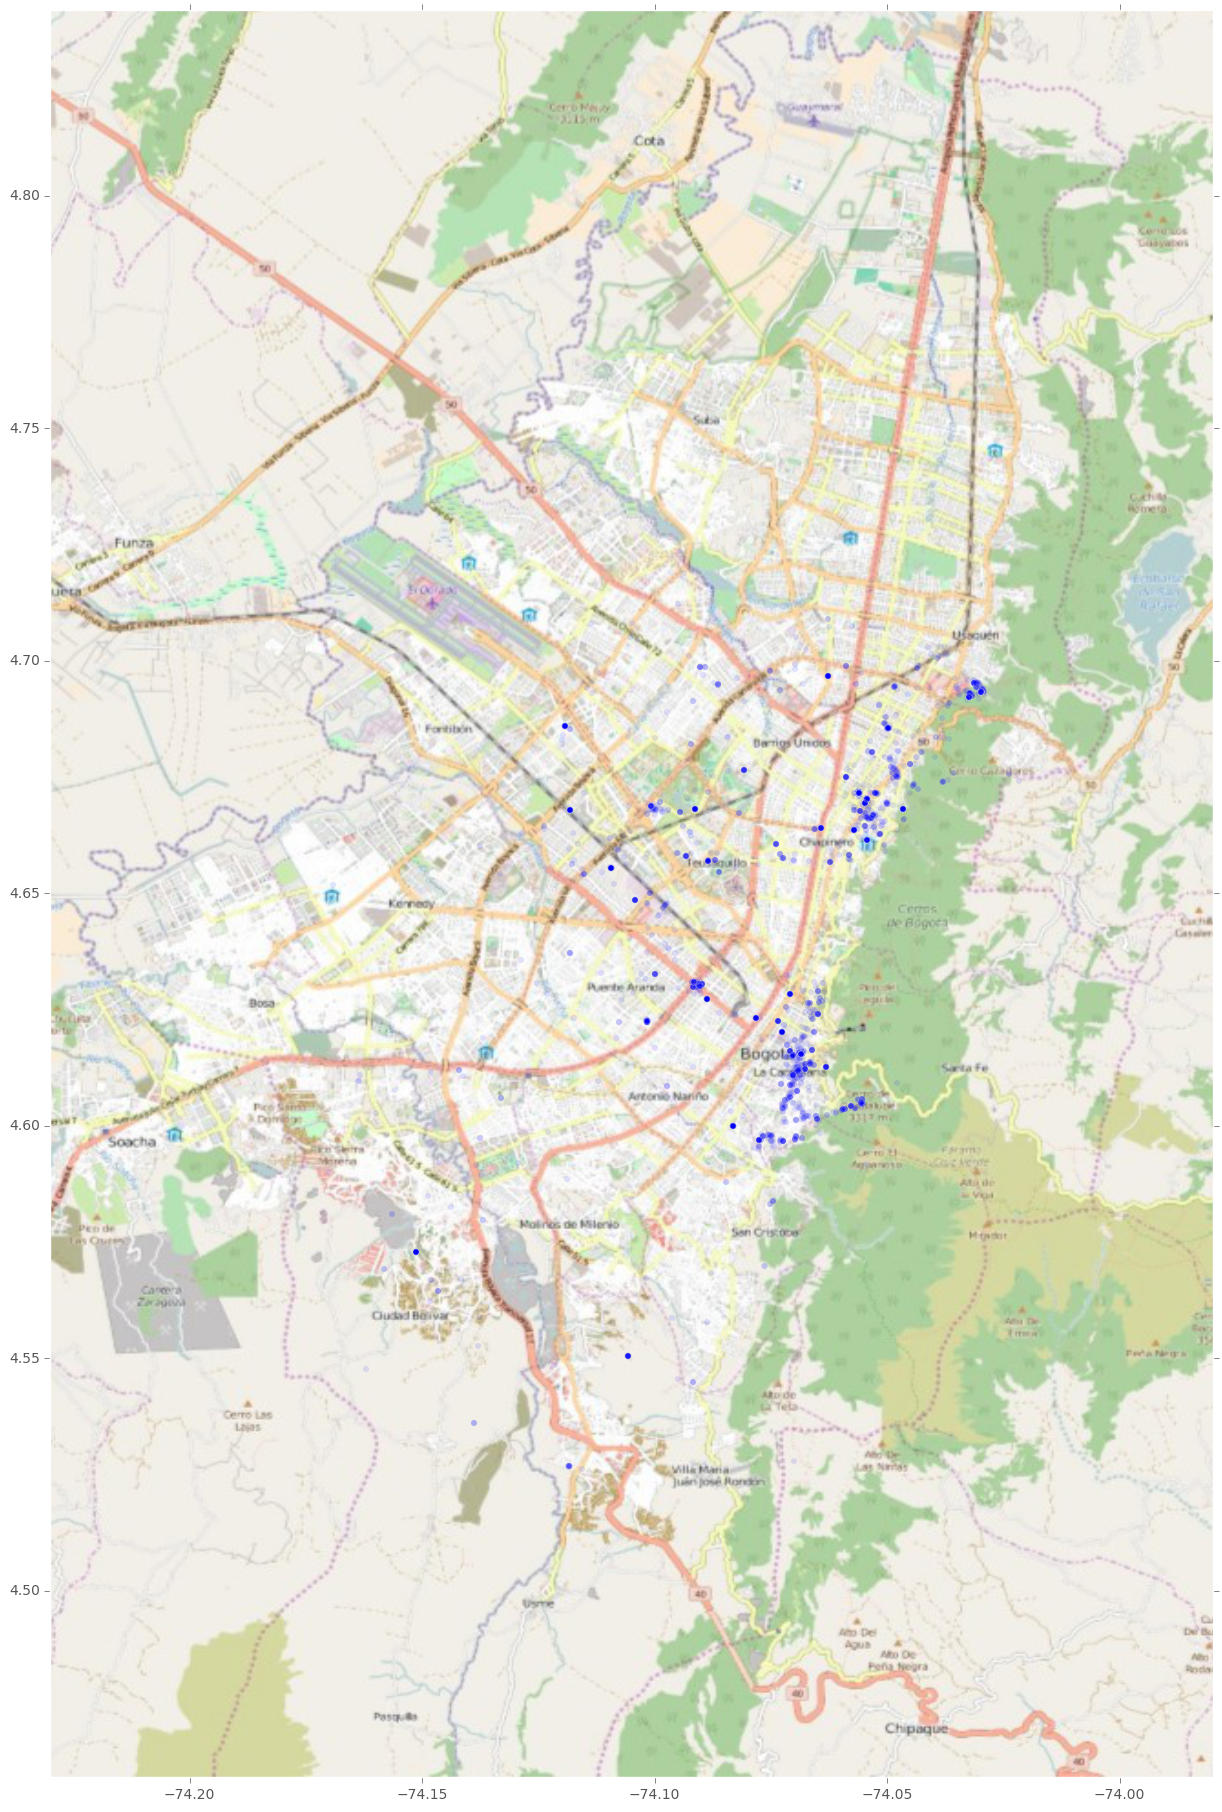

In [9]:
img = imread("map2.jpg")
plt.figure(figsize=(map_dim(15)[0],map_dim(15)[1]))
plt.imshow(img,zorder=1, extent=[-74.23, -73.98,4.46,  4.84])
plt.scatter(Long, Lat, alpha=0.1,zorder=2)
plt.ylim(4.46,4.84)
plt.xlim(-74.23, -73.98)
plt.savefig('mapa_puntos.jpg')
plt.show()


### Plot Density by coordinates

http://sebastianraschka.com/Articles/2014_kernel_density_est.html

## Tags processing

### MATRIZ tf-idf sin stemming


In [10]:
tokens_list = []
counter = 0

regex_str = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

regex_rem = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
tokens_remove = re.compile(r'('+'|'.join(regex_rem)+')', re.VERBOSE | re.IGNORECASE)

punctuation = list(string.punctuation)
stopEn = stopwords.words('english') + punctuation + ['rt', 'via']
stopEs = stopwords.words('spanish') + punctuation + ['rt', 'via']

def tokenize(s):
    return tokens_re.findall(s)
          
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token.lower() for token in tokens]
    return tokens

In [11]:
#with open(path+'iot_data_130516.txt', 'r') as f:
#for line in list(set(Tags)): #Unrepeated tags list (n:600)
#for line in Tags: #Total Tags List
for line in Texts: #Total Texts List
    #counter+=1
    #if counter == 500:
    #    break;
    tag = line
    tagString = ""
    for term in preprocess(tag):
        if not tokens_remove.search(term) and term not in stopEn and term not in stopEs:
            tagString = tagString + term + " "
    tokens_list.append(tagString)
    
#print counter

tfidf = TfidfVectorizer(max_df=0.5, min_df=2)
tfs = tfidf.fit_transform(tokens_list)

print "Dimensiones tf-idf",tfs.shape
#print tfidf
#print tfidf.idf_
#print tfs    


Dimensiones tf-idf (4000, 2410)


### Removing Stopwords

In [12]:
tfidf = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
#tfidf = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='spanish')
tfs = tfidf.fit_transform(tokens_list)

print "Dimensiones tf-idf",tfs.shape
#print tfidf
#print tfidf.idf_
#print tfs  

#Tokens
#tokens_list#[0]

Dimensiones tf-idf (4000, 2358)


### Cosine similarity

In [13]:
similarity_matrix = cosine_similarity(tfs)
similarity_matrix
#similarity_matrix[0,:]
#similarity_matrix[:,1]

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.13535007,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.01073812,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.01073812, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.13535007,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

### Entropy

In [14]:
#Hamming distance
def hamming(x, y):
    sim = 0.0
    for i in range(len(x)):
        if x[i] == y[i] and x[i] != 0 and y[i] != 0:
            sim += 1
            
    sim = sim/len(x)
    return sim

#Entropy
def entropy(x):
    entropy = 0
    for i in range(0,len(x)-1):
        for j in range(i+1, len(x)):
            sim = hamming(x[i,:], x[j,:])
            if sim != 0:
                entropy += (sim*log(sim,2))+((1-sim)*log(sim,2))
    return -1*entropy


In [15]:
'''
#Entropy analisis
time_start=time.time()
entropyT = entropy(similarity_matrix)
dimensions = [] 
similarity_matrix = np.delete(similarity_matrix, (0), axis = 0)
for i in range(1,len(x)-1):
    entropyTemp = entropy(similarity_matrix)
    if(entropyT-entropyTemp < entropyT):
        similarity_matrix = np.delete(similarity_matrix, (i), axis = 0)
        dimensions.append(i)

time_end=time.time()

print "Tiempo de procesamiento:", time_end-time_start
print "Entropy"
print dimensions
print entropyT
#print entropy(similarity_matrix)'''


'\n#Entropy analisis\ntime_start=time.time()\nentropyT = entropy(similarity_matrix)\ndimensions = [] \nsimilarity_matrix = np.delete(similarity_matrix, (0), axis = 0)\nfor i in range(1,len(x)-1):\n    entropyTemp = entropy(similarity_matrix)\n    if(entropyT-entropyTemp < entropyT):\n        similarity_matrix = np.delete(similarity_matrix, (i), axis = 0)\n        dimensions.append(i)\n\ntime_end=time.time()\n\nprint "Tiempo de procesamiento:", time_end-time_start\nprint "Entropy"\nprint dimensions\nprint entropyT\n#print entropy(similarity_matrix)'

## Plots

### Heatmap

In [16]:
#plt.figure(figsize=(15,15))
#heatmap = plt.pcolor(similarity_matrix,cmap=mpl.cm.Blues )